# Scrape sessions from team surfs (Smartfin @ Surfrider)

### Imports

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np
from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.integrate import cumtrapz
import os
import datetime
import pytz
import re

import requests

import mpld3
import folium
import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

%matplotlib notebook

### Ride list
Create a list of ride (session) identifiers manually (looking at surf.smartfin.org and known fin identifiers).

In [14]:
ride_ids = ['14827']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)

### Set up functions to scrape by ride ID

In [15]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' # OMG I can't believe this is how we're doing this. 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample

### Append to lists of dataframes then concatenate and merge
1. First, loop through function(s) above using known session IDs, generating a dataframe for each rid (ride identifier). 
2. Next, append each dataframe (one motion, one temperature DF for each rid) to corresponding lists of DFs.
3. Use pandas concatenate function to turn appended lists into a mega dataframe of all dataframes, using rid as index
4. Rename some cols as needed
5. Merge motion and temperature DFs

*Note*: temp DF is called "ocean" due to surf.smartfin.org's nomenclature (e.g., ocean.csv, ocean.json, etc.)

In [16]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

# Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride ", rid, "so far so good")
            count_good_fins += 1
        
    except: 
        print("Ride ", rid, " ain't workin'")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, whatever that means-> a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])

# Just in case it's helpful to have descriptive column headers...
ocean_df.columns.values[1] = 'V_temp_int (ADC counts)'
ocean_df.columns.values[2] = 'temp_int_cal (oC)' # this column is just copied from temp_ext
ocean_df.columns.values[4] = 'V_temp_ext (ADC counts)'
ocean_df.columns.values[5] = 'temp_ext_cal (oC)' 

# Merge to get lat/lon in temp DF
full_df = pd.merge(ocean_df, motion_df, left_index = True, right_index = True)
print(len(full_df))

https://surf.smartfin.org/ride/14827
https://surf.smartfin.org/media/201807/google_117589279598321562176_000666D321BE_180723164430_Ocean.CSV
                               Time  Temperature 1  Calibrated Temperature 1  \
UTC                                                                            
2018-07-23 16:44:42.467  1370665472            493                    30.812   
2018-07-23 16:44:48.487  1370671492            496                    31.000   
2018-07-23 16:44:54.507  1370677512            499                    31.188   
2018-07-23 16:45:00.528  1370683533            500                    31.250   
2018-07-23 16:45:06.549  1370689554            500                    31.250   
2018-07-23 16:45:12.569  1370695574            502                    31.375   
2018-07-23 16:45:18.591  1370701596            502                    31.375   
2018-07-23 16:45:24.612  1370707617            504                    31.500   
2018-07-23 16:45:30.634  1370713639            505         

30637


### Filter using temp, temp rate of change, and motion and modify the CSV data above to give out useful measurements in acceleration, gyro, and magnetic with direction relative to the board

In [17]:
#%% Filter         
# Grab int and ext for better readability
temp_int = full_df.loc[:, 'temp_int_cal (oC)']
temp_ext = full_df.loc[:, 'temp_ext_cal (oC)']
temp_diff_pre = temp_ext-temp_int
diff_temp_diff_pre = np.diff(temp_diff_pre)
diff_temp_diff_pre = np.append(diff_temp_diff_pre, diff_temp_diff_pre[-1]) # derivative of the difference
A2 = full_df.loc[:, 'IMU A2'] # z-dimension (into board)
print(len(A2))

# Get rid of data outside of this temp difference range
simple_filter = (A2 < 2000)
full_df_filt = full_df[simple_filter]

# Grab int and ext again after filter
temp_int = full_df_filt.loc[:, 'temp_int_cal (oC)']
temp_ext = full_df_filt.loc[:, 'temp_ext_cal (oC)']
temp_diff_post = temp_ext-temp_int

full_df_filt.head(20)
print (full_df_filt.head(20))     # If you want to see the headings/data type of each column


full_df_filt_mod = full_df_filt    # Make a copy of the original filtered data as to not modify it in case it
                                   # needs to be called to again for other reasons
    
    

# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places
# and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2
full_df_filt_mod.loc[:, 'IMU A1'] = full_df_filt_mod.loc[:, 'IMU A1'] / 512 * 9.81
full_df_filt_mod.loc[:, 'IMU A2'] = full_df_filt_mod.loc[:, 'IMU A2'] / 512 * 9.81
full_df_filt_mod.loc[:, 'IMU A3'] = full_df_filt_mod.loc[:, 'IMU A3'] / 512 * 9.81

# Correct the IMU Gyroscopic columns into units of degrees/sec
# Dividing by 8.2 is equivalent to multiplying by 4 to correct bit shifting by 2 places
# and dividing by 32.8 to convert bits into degrees/sec
full_df_filt_mod.loc[:, 'IMU G1'] = full_df_filt_mod.loc[:, 'IMU G1'] / 8.2
full_df_filt_mod.loc[:, 'IMU G2'] = full_df_filt_mod.loc[:, 'IMU G2'] / 8.2
full_df_filt_mod.loc[:, 'IMU G3'] = full_df_filt_mod.loc[:, 'IMU G3'] / 8.2

# Correct the IMU Magnetometer columns into units of microTeslas
# There is no bit shifting done here in the firmware, so we only have to convert bits to microTeslas by multiplying by 0.15
full_df_filt_mod.loc[:, 'IMU M1'] = full_df_filt_mod.loc[:, 'IMU M1'] #* 0.15
full_df_filt_mod.loc[:, 'IMU M2'] = full_df_filt_mod.loc[:, 'IMU M2'] #* 0.15
full_df_filt_mod.loc[:, 'IMU M3'] = full_df_filt_mod.loc[:, 'IMU M3'] - 100 #* 0.15 # -100 is to fix inductive pad field reading

# Edit the titles of the columns so that they display the units of the data presented in each column
# IMPORTANT NOTE!!!! Remember axis direction!!
#      *FOR ACCELERATION AND GYRO, Right-sided fins (in relation to forward movement) have A1 pointed backwards,
#       A2 pointed straight down, and A3 pointed to the right
#      *FOR MAGNETO, right-sided fins have X (M1) pointing down, Y (M2) pointing backwards, and Z (M3) pointing left
full_df_filt_mod = full_df_filt_mod.rename(columns=({'IMU A1':'IMU A1 [m/s^2] long axis - = forwards', 'IMU A2':'IMU A2 [m/s^2] vertical + = down', 'IMU A3':'IMU A3 [m/s^2] short axis + = right'}))
full_df_filt_mod = full_df_filt_mod.rename(columns=({'IMU G1':'IMU G1 [deg/s] + = flip left','IMU G2':'IMU G2 [deg/s] + = turning right','IMU G3':'IMU G3 [deg/s] pitch upwards'}))
full_df_filt_mod = full_df_filt_mod.rename(columns=({'IMU M1':'IMU M1 [uTeslas] + = looking forward','IMU M2':'IMU M2 [uTeslas] + = looking upwards','IMU M3':'IMU M3 [uTeslas] + = looking right'}))
# Not sure if the IMU 1,2,3 correspond with a certain direction (i.e. A2, G2, M2, all face down into water) or that each
#     IMU corresponds with certain labeled axis (i.e. IMU 1 is always X-axis, IMU 2 is always Y-axis...)
# The current labels correspond to ASSUMPTION 1 (CONFIRMED)

# For this table to output the correct values, full_df_filt has to be run again, and this run after it but only once
# I know it has to do with the structure that python handles this with (which would be pointer type) and I don't know how to
#      work around that without going through a lengthy complicated process I'm not sure I can do reliably.

# I will join the two codes into one cell evetually to eliminate this problem, but I keep them separate 
#      for now to keep each step separate.

# Print out the modified table with unit labels
print("For some reason, the table doesn't display IMU A1 column at output.")
print("The proper name for IMU A1 is 'IMU A1 [m/s^2] long axis - = forwards' for reference. Negative value\
means going directly forward on the board.")

full_df_filt_mod.head(20)
#print(full_df)

#To print out the time_stamp "Time_y" for the table (so that it's not N/A):
#print(full_df_filt_mod.loc[:,"Time_y"])

30637
                                 Time_x  V_temp_int (ADC counts)  \
ride_id UTC                                                        
14827   2018-07-23 16:44:42.915     NaN                      NaN   
        2018-07-23 16:44:42.948     NaN                      NaN   
        2018-07-23 16:44:42.981     NaN                      NaN   
        2018-07-23 16:44:43.014     NaN                      NaN   
        2018-07-23 16:44:43.047     NaN                      NaN   
        2018-07-23 16:44:43.080     NaN                      NaN   
        2018-07-23 16:44:43.113     NaN                      NaN   
        2018-07-23 16:44:43.146     NaN                      NaN   
        2018-07-23 16:44:43.179     NaN                      NaN   
        2018-07-23 16:44:43.212     NaN                      NaN   
        2018-07-23 16:44:43.245     NaN                      NaN   
        2018-07-23 16:44:43.278     NaN                      NaN   
        2018-07-23 16:44:43.311     NaN   

/Users/jasminesimmons/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:630: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



For some reason, the table doesn't display IMU A1 column at output.
The proper name for IMU A1 is 'IMU A1 [m/s^2] long axis - = forwards' for reference. Negative valuemeans going directly forward on the board.


Time_x  V_temp_int (ADC counts)  \
ride_id UTC                                                        
14827   2018-07-23 16:44:42.915     NaN                      NaN   
        2018-07-23 16:44:42.948     NaN                      NaN   
        2018-07-23 16:44:42.981     NaN                      NaN   
        2018-07-23 16:44:43.014     NaN                      NaN   
        2018-07-23 16:44:43.047     NaN                      NaN   
        2018-07-23 16:44:43.080     NaN                      NaN   
        2018-07-23 16:44:43.113     NaN                      NaN   
        2018-07-23 16:44:43.146     NaN                      NaN   
        2018-07-23 16:44:43.179     NaN                      NaN   
        2018-07-23 16:44:43.212     NaN                      NaN   
        2018-07-23 16:44:43.245     NaN                      NaN   
        2018-07-23 16:44:43.278     NaN                      NaN   
        2018-07-23 16:44:43.311     NaN                      NaN   
        2018-07-23 16:44:43.344     NaN                      NaN   
        2018-07-23 16:44:43.377     NaN                      NaN   
        2018-07-23 16:44:43.410     NaN                      NaN   
        2018-07-23 16:44:43.443     NaN                      NaN   
        2018-07-23 16:44:43.476     NaN                      NaN   
        2018-07-23 16:44:43.509     NaN                      NaN   
        2018-07-23 16:44:43.542     NaN                      NaN   

                                 temp_int_cal (oC)  Temperature 1 Stable  \
ride_id UTC                                                                
14827   2018-07-23 16:44:42.915                NaN                   NaN   
        2018-07-23 16:44:42.948                NaN                   NaN   
        2018-07-23 16:44:42.981                NaN                   NaN   
        2018-07-23 16:44:43.014                NaN                   NaN   
        2018-07-23 16:44:43.047                NaN                   NaN   
        2018-07-23 16:44:43.080                NaN                   NaN   
        2018-07-23 16:44:43.113                NaN                   NaN   
        2018-07-23 16:44:43.146                NaN                   NaN   
        2018-07-23 16:44:43.179                NaN                   NaN   
        2018-07-23 16:44:43.212                NaN                   NaN   
        2018-07-23 16:44:43.245                NaN                   NaN   
        2018-07-23 16:44:43.278                NaN                   NaN   
        2018-07-23 16:44:43.311                NaN                   NaN   
        2018-07-23 16:44:43.344                NaN                   NaN   
        2018-07-23 16:44:43.377                NaN                   NaN   
        2018-07-23 16:44:43.410                NaN                   NaN   
        2018-07-23 16:44:43.443                NaN                   NaN   
        2018-07-23 16:44:43.476                NaN                   NaN   
        2018-07-23 16:44:43.509                NaN                   NaN   
        2018-07-23 16:44:43.542                NaN                   NaN   

                                 V_temp_ext (ADC counts)  temp_ext_cal (oC)  \
ride_id UTC                                                                   
14827   2018-07-23 16:44:42.915                      NaN                NaN   
        2018-07-23 16:44:42.948                      NaN                NaN   
        2018-07-23 16:44:42.981                      NaN                NaN   
        2018-07-23 16:44:43.014                      NaN                NaN   
        2018-07-23 16:44:43.047                      NaN                NaN   
        2018-07-23 16:44:43.080                      NaN                NaN   
        2018-07-23 16:44:43.113                      NaN                NaN   
        2018-07-23 16:44:43.146                      NaN                NaN   
        2018-07-23 16:44:43.179                      NaN                N

### Calculate elapsed time

In [18]:
#%% Get elapsed time per session after filtering
good_rides = (motion_df.index.get_level_values(0).unique()) # get all names
n_rides = len(good_rides)
idx = pd.IndexSlice

total_sesh_sec = 0 # increment each successful session

# Make plot of each good session (ride)
for n in range(0, n_rides): #n_rides
    this_ride = good_rides[n]
    try:
        this_ride_df = full_df_filt.xs(good_rides[n], level = 'ride_id', axis = 0)
        session_duration_sec = this_ride_df['elapsed'][-1]-this_ride_df['elapsed'][0]
        print(this_ride, session_duration_sec)
        if session_duration_sec/60 > 15:
            total_sesh_sec += session_duration_sec
    except:
        print('meh')

14827 nan


### Calculate Compass Heading Direction from Magnetometer Data

In [19]:
# Iterate through to get the data from the columns and run calculations
y_ax = full_df_filt_mod.loc[:, 'IMU M2 [uTeslas] + = looking upwards'] #* (-1)
x_ax = full_df_filt_mod.loc[:, 'IMU M3 [uTeslas] + = looking right'] #* (-1)
z_ax = full_df_filt_mod.loc[:, 'IMU M1 [uTeslas] + = looking forward']

# The original calculations that I learned this method from used Gauss as units,
# but units cancel anyways in arctan


# Calculate the direction D by first checking to see if the X data is equal to 0 to prevent
# divided by zero erros in calculations. If the X data is 0, check to see if the Y data < 0
# If Y < 0, the direction D = 90 degrees heading; if Y > 0, the direction D = 0 degrees.
# If X data != 0, then calculate the arctan of Y and X and convert from polar to degrees
# If D is greater than 360 degrees, substract 360 degrees from that value
# If D is less than 0 degrees, add 360 degrees to that value

# I got this method from the website below:
# https://blog.digilentinc.com/how-to-convert-magnetometer-data-into-compass-heading/

comp_heading = [np.float(0.0)] * len(x_ax)

#print(comp_heading)
# for i in x_ax:
#    if x_ax[i] == 0.0:
#        if y_ax[i] < 0.0:
#            comp_heading[i] = 90.0
#        elif y_ax[i] > 0.0:
#            comp_heading[i] = 0.0
#        else:
#            print("There was a reading of 0,0 for magnetometer in y-axis and x-axis. List not completed.")
#    else:
#        comp_heading[i] = np.arctan(y_ax[i]/x_ax[i]) * (180.0/np.pi)
#comp_heading = np.arctan(y_ax/x_ax) * (180/np.pi)
print(full_df_filt_mod.loc[:, 'IMU M3 [uTeslas] + = looking right'])
count = 0

print("Converting magneto data from guessed x-axis and y-axis to compass heading in deg:")
#for x in np.nditer(comp_heading, op_flags=['readonly'], op_dtypes=['float64']):
    #for i, j in np.nditer(op=[x_ax, y_ax], op_flags=['readonly'], op_dtypes=['float64']):
for i,j,x in np.nditer([x_ax,y_ax,comp_heading]):
#    for i,j in np.c_[x_ax,y_ax]:
        #print("ij: %f:%f" % (i,j))
    if i == np.float(0):
        print('i = 0')
        if j < np.float(0):
            print('j < 0')
            x = np.float64(90)
        elif j > np.float64(0):
            print('j > 0')
            x = np.float64(0)
        else:
            print("There was a reading of 0,0 for magnetometer in y-axis and x-axis. List not completed")
    else:
        x = np.arctan(j/i) * (180/np.pi)

    if x < np.float64(0):
        x += np.float64(360)
    print(x)
    count+= 1
print("Total number of readings for RID 13735: {}".format(count))


ride_id  UTC                    
14827    2018-07-23 16:44:42.915    -17.0
         2018-07-23 16:44:42.948     -7.0
         2018-07-23 16:44:42.981      7.0
         2018-07-23 16:44:43.014      8.0
         2018-07-23 16:44:43.047     26.0
         2018-07-23 16:44:43.080     33.0
         2018-07-23 16:44:43.113     41.0
         2018-07-23 16:44:43.146     44.0
         2018-07-23 16:44:43.179     36.0
         2018-07-23 16:44:43.212     35.0
         2018-07-23 16:44:43.245     29.0
         2018-07-23 16:44:43.278     37.0
         2018-07-23 16:44:43.311     53.0
         2018-07-23 16:44:43.344     62.0
         2018-07-23 16:44:43.377     65.0
         2018-07-23 16:44:43.410     63.0
         2018-07-23 16:44:43.443     71.0
         2018-07-23 16:44:43.476     60.0
         2018-07-23 16:44:43.509     61.0
         2018-07-23 16:44:43.542     73.0
         2018-07-23 16:44:43.575     71.0
         2018-07-23 16:44:43.608     69.0
         2018-07-23 16:44:43.641     78.0
 

280.15426658
279.148852986
279.016048948
279.148852986
277.230242639
279.811256868
280.399238112
279.637538113
282.002294899
278.680418425
280.724448537
279.598903069
279.081969573
278.365886124
279.811256868
280.208226359
280.080597988
279.462322208
278.426969021
280.15426658
278.0080668
280.057308915
278.434864265
280.109298492
279.637538113
279.216720248
278.927529592
279.039482803
278.860720938
279.064189908
279.709437408
277.948403874
278.130102354
279.462322208
277.953081971
280.381805159
277.876302112
278.777817386
278.84181456
278.249344179
278.365886124
279.064189908
278.951070642
279.081969573
280.399238112
278.972626615
278.0080668
277.707485723
278.130102354
279.958070598
280.713123023
279.039482803
279.039482803
278.488943881
276.993904954
279.56668599
278.488943881
279.709437408
280.632908984
278.551830234
278.746162263
277.831689534
279.739445945
280.381805159
279.958070598
277.338606336
278.906744184
277.305759533
278.130102354
278.714732875
279.039482803
278.498558879


277.637776946
276.488115117
277.823710732
276.245252679
275.951422279
278.004728857
279.090276921
276.877934979
276.632514615
278.068626219
277.294196309
277.489952685
276.581944655
277.507346667
275.114013831
274.799836114
274.053554232
277.317007232
276.773512909
276.911227119
277.284023654
275.754565331
278.372110543
276.709836808
274.950272234
277.153564318
276.581944655
276.532136688
277.338606336
277.883139317
277.317007232
275.036044295
277.523820439
275.624628041
277.823710732
276.590608768
274.997942094
277.206057001
277.765166018
277.815293547
276.877934979
277.943471811
276.632514615
276.340191746
278.004728857
277.876302112
278.130102354
277.098404284
278.252529047
276.532136688
278.130102354
276.911227119
277.338606336
276.193904967
276.931356798
277.943471811
278.860720938
278.130102354
276.38874748
277.696051722
277.016501745
277.889617808
277.098404284
277.236922026
276.193904967
278.255888715
276.825326464
277.637776946
278.130102354
277.450249069
277.206057001
277.580

283.659656913
284.036243468
282.696548952
284.243460574
281.821488341
285.101098161
285.883853734
284.243460574
284.359336544
285.255118703
283.614182745
284.089941465
284.875682002
284.987561971
284.875682002
283.091893064
283.570434385
283.765215312
285.176577588
282.600159826
284.142346642
282.765565781
284.036243468
283.928341939
283.659656913
282.030596097
283.227796003
284.089941465
283.330264853
285.642246457
284.25703536
283.477822753
282.016162093
283.706961004
282.359508727
282.961401851
283.717346318
284.987561971
283.614182745
283.091893064
283.62699486
286.782644145
285.443590982
285.018360631
285.443590982
284.089941465
284.088283217
284.4567554
283.727096579
284.036243468
283.882360813
281.717434703
283.68225816
283.727096579
283.412357642
281.393698174
283.882360813
283.934835115
283.190610712
281.793429685
282.300538879
283.431028871
283.373009394
282.211508376
280.103037001
281.675386069
281.551007263
283.114544988
281.857826233
281.148989696
280.359052488
280.6579460

323.130102354
316.684684318
306.634113876
316.735704589
309.472459848
304.875328345
310.100907546
316.636577042
316.636577042
312.207297634
308.659808254
310.236358309
316.974934011
313.264295411
318.17983012
316.789910608
308.911471846
319.635463427
315.0
299.054604099
315.0
307.694240467
302.660912722
305.788973459
310.100907546
304.380344724
302.905242923
306.573030979
318.814074834
304.114472945
307.405356631
304.875328345
318.814074834
310.91438322
294.44395478
306.253837737
304.215702132
303.231711068
304.695153531
301.607502246
300.256437164
291.801409486
300.068582822
301.759480085
307.874983651
315.0
288.434948823
277.125016349
299.744881297
303.690067526
289.983106522
300.963756532
71.5650511771
286.389540334
81.0273733851
288.434948823
273.012787504
78.690067526
i = 0
j > 0
0.0
71.5650511771
59.0362434679
315.0
78.690067526
323.130102354
348.690067526
296.565051177
356.987212496
315.0
341.565051177
315.0
323.130102354
347.735226272
12.9946167919
356.633539337
345.579226872
3

284.036243468
293.198590514
297.645975364
311.185925166
278.746162263
280.491477012
278.130102354
282.264773728
277.594643369
288.434948823
285.524110997
i = 0
j > 0
0.0
281.309932474
277.305759533
283.736268306
277.305759533
293.198590514
279.246112746
285.255118703
282.264773728
287.020525612
280.840305454
i = 0
j > 0
0.0
277.523820439
281.768288932
287.020525612
272.045408489
276.340191746
281.725112015
281.309932474
273.691385986
276.115503566
89.0289780689
280.954062643
278.673174048
280.007979801
283.570434385
270.881403997
282.225122676
279.605204155
277.883139317
287.354024636
291.037511025
282.87500156
280.097504384
284.82647997
271.468800714
278.343891584
274.289153329
271.397181027
273.012787504
271.218875235
271.218875235
89.3704013916
279.272601777
273.65222278
275.946863054
273.900493742
273.366460663
281.093723012
277.969610394
281.944177188
282.355359865
283.535856369
283.150948681
280.124671655
285.802513954
280.885527055
280.561010691
283.781597236
284.500166767
282.8

349.67274611
348.395237644
349.902495616
349.094977955
350.166436036
349.489956631
349.930937301
349.104496317
350.706691401
352.015133785
348.486168816
347.275644315
349.203456828
348.996459148
349.582144251
347.905242923
348.098393762
349.96196734
348.690067526
349.19176906
351.135376612
349.19176906
350.579347442
349.489956631
349.62415508
350.02228738
348.486168816
347.868678933
348.284440465
350.537677792
349.273705534
349.602666478
349.582144251
347.905242923
348.481340655
350.537677792
348.589016873
348.293563271
351.080156216
351.135376612
349.39614174
350.410448291
350.410448291
348.794052493
348.789366871
349.203456828
348.794052493
349.104496317
350.581717583
353.829824905
349.837916806
350.3237289
347.868678933
349.875328345
349.114472945
350.3237289
346.630661412
349.094977955
350.02228738
348.284440465
349.67274611
349.104496317
348.690067526
351.582342823
349.39614174
348.589016873
347.993798926
348.886959464
349.786027015
350.200151331
348.098393762
350.200151331
349.06

344.259335467
343.992595704
343.660303742
344.782038088
343.342154443
343.421209225
342.597295869
341.956587995
344.88652694
344.027867853
344.53878226
347.363290762
346.890791802
347.034146147
348.303983211
346.835282433
347.702307126
347.850908393
350.631553917
349.297152404
350.441918918
349.592288688
349.307787845
349.0133125
349.804011753
351.222182614
349.567789353
351.006207601
352.042474773
350.837652954
350.918030427
350.744272255
350.571966106
351.176138057
352.874983651
349.84573342
351.988768387
350.811163923
352.046918029
352.225399472
352.168310466
351.093255816
352.822754149
351.869897646
351.810707812
351.812197988
352.746805387
352.325520483
352.977206164
352.261561913
354.24859791
352.046918029
353.480198248
352.67359334
352.09839406
354.369317242
353.125181971
352.704243221
351.756553027
352.568592029
349.923702529
351.544972323
351.125147658
350.31121344
349.20689688
352.851080532
350.256358713
351.066738394
348.160965869
348.160965869
349.451934582
347.932231041
34

347.111814874
348.413723465
348.690067526
346.184974659
345.160060838
347.005383208
345.256437164
345.801445976
344.981639369
344.592296359
345.481389991
344.374040006
344.744881297
344.931511841
345.041363926
346.113093586
345.108659136
345.379126011
346.551384948
346.644659037
347.275644315
345.465544919
348.059602965
348.215251494
350.735476015
347.905242923
348.070677823
348.845340261
349.159694546
350.015039795
349.9456644
350.406865737
350.406865737
349.451934582
350.472716619
350.799599531
351.027373385
350.965005
351.813614973
351.209456817
353.220432055
351.698695627
350.635507713
352.431602978
352.60297293
351.299809201
351.027373385
351.58765471
354.269778299
352.325520483
352.378928691
353.30199383
352.225399472
351.285267125
352.168310466
352.225399472
353.20616944
353.659808254
352.225399472
352.46055486
351.869897646
352.746805387
352.954230875
351.929767822
353.704570573
351.926795124
353.835158218
354.189900572
351.299809201
352.431602978
351.299809201
352.949749741
35

342.281211123
343.584720324
342.863725496
342.590697253
343.504011522
342.774281199
344.320475878
344.021273225
346.022642205
345.448623544
347.337635937
347.471192291
348.882657656
347.922330838
351.805736665
350.61448174
350.387885246
352.874983651
351.93306827
352.793942999
355.328621965
352.793942999
354.122607393
352.715976346
353.226487091
351.689722832
352.769757361
352.793942999
351.004654996
353.19094982
352.051596126
349.540090907
351.501441121
348.690067526
351.614399765
349.446126302
348.775839587
348.282565297
348.690067526
348.360311285
349.098732347
349.354336655
349.106453942
350.571966106
350.134193057
348.533307918
349.731694202
350.699621339
348.059602965
348.132268102
349.084117568
348.132268102
350.0892552
348.439869206
349.446126302
348.609369298
349.176988774
351.006207601
348.524473249
350.811163923
349.0133125
350.744272255
351.627889457
348.934224199
350.260554055
352.640912318
351.985763574
351.222182614
352.234833982
352.168310466
353.426139976
354.805571092

353.125181971
352.551282126
353.076551085
352.949749741
352.551282126
354.550113895
354.189900572
353.835158218
355.749345425
353.395164503
353.792232778
353.173137662
352.825675764
352.923621822
352.998732443
353.348903975
352.207921922
352.431602978
352.038249109
354.662600012
352.958522533
352.923621822
353.233825177
353.659808254
352.585369709
353.911471846
352.393132228
351.166585349
351.166585349
350.968928204
350.569176293
349.49493613
349.064055553
348.388513576
348.917430537
347.988521614
346.644659037
345.296448176
346.203888318
345.479850981
346.736671257
345.579226872
346.944752776
346.818853928
345.001318496
345.001318496
345.963756532
344.441129182
346.908106936
347.070529035
345.857653358
345.699722551
348.258631558
348.064397457
347.811366798
349.205457938
348.337211143
350.172275989
350.82379666
352.92965518
350.644506343
351.809138624
353.751628335
353.565260849
353.565260849
353.226487091
353.386539518
354.165211003
354.207203505
351.869897646
354.269778299
353.88449

351.448169766
351.744111285
353.612882974
352.110382192
352.694240467
352.349349045
351.501441121
352.901595716
352.110382192
351.988768387
351.501441121
353.754747321
352.822754149
353.19094982
355.002057906
352.822754149
352.661393664
352.476179561
351.396878221
351.565135735
351.222182614
353.267078673
350.505970114
346.062202792
344.407189061
346.798912824
346.243792325
350.154177632
354.49958853
354.053136946
353.969991192
352.724995042
353.751628335
351.412064404
343.385575511
343.300755766
344.708572189
344.710008642
344.13841064
345.465544919
347.64844085
346.70142967
346.496499906
347.064542484
346.885455012
347.404543489
347.404543489
349.392569127
348.690067526
348.609369298
350.038887901
350.038887901
348.934224199
350.503141461
351.333882083
350.892665688
350.607550659
349.676411046
348.774202237
349.714622025
349.791773641
349.540090907
351.627889457
350.394795845
351.139279062
348.690067526
352.738889419
352.434678932
350.041929402
350.143529179
349.867788434
351.2221826

344.400914197
345.256437164
344.315885973
348.799202212
349.430008779
350.942111871
351.054618166
352.1553039
355.072890052
353.659808254
356.248270929
354.126038484
353.711148545
353.327800003
355.364536573
353.516926307
352.848172338
355.100907546
353.254420353
354.618452948
353.927543593
354.207203505
354.351752626
354.023297617
355.375848672
355.794642998
353.990994043
354.61068824
354.925269622
353.908486291
354.312008747
352.609590791
354.093858886
350.821921
350.079987038
347.388114853
345.30658663
344.357753543
341.565051177
344.396052855
343.636863249
340.839826878
342.439727948
341.141691053
342.529071872
343.159881285
343.399986321
344.816996777
344.962184096
346.415685824
348.690067526
347.195733935
349.600761888
351.269963766
351.004654996
348.690067526
349.636308178
349.9145237
350.387885246
349.237462777
350.682913931
350.278757375
351.236820874
350.095816787
351.679757483
350.172275989
351.807483967
351.304497123
351.805736665
350.676408222
350.935810092
351.436784452
3

351.027373385
349.859206854
349.88355695
350.909723079
352.933270284
351.326825952
351.480577843
352.990615743
350.794937421
351.342448523
350.499758685
349.408472252
351.869897646
351.480577843
350.265767659
352.184706453
352.328778517
351.556809071
351.934858819
351.288562448
351.076011556
353.711148545
350.537677792
350.61448174
350.722860662
351.480577843
352.061735476
348.333644257
351.614399765
352.123697888
353.047042532
352.328778517
350.31121344
349.13147466
350.61448174
351.869897646
351.412064404
351.99879682
352.467398599
351.805736665
352.450578232
351.288562448
351.74056202
350.499758685
353.558399901
352.31601817
351.35719742
351.42476736
351.607074813
352.20300889
350.387885246
350.690059825
350.837652954
351.54801463
351.74056202
350.837652954
350.233320604
349.859206854
352.959283413
351.42476736
351.050541916
352.405356631
351.42476736
352.002526528
352.193599171
352.303948278
351.807483967
353.263988786
351.805736665
350.428404346
351.614399765
348.430027952
349.966

351.004654996
351.304497123
353.277523488
352.051596126
352.176289268
353.565260849
353.565260849
352.605991357
352.362223054
353.226487091
352.661393664
352.292514277
353.945808106
351.093255816
351.929767822
352.110382192
351.809138624
353.277523488
351.988768387
353.277523488
352.769757361
352.281667206
352.586804291
351.093255816
352.116860683
352.234833982
353.140239994
352.168310466
352.419627062
352.769757361
352.176289268
351.9919332
353.61125252
351.027373385
352.51496105
353.659808254
352.715976346
351.750655821
352.046918029
353.85337434
351.004654996
352.977206164
352.176289268
352.605991357
351.319581575
351.928243633
352.234833982
353.088772881
352.738889419
353.516926307
350.783279752
354.035512899
352.983498255
352.051596126
351.929767822
352.110382192
352.901595716
351.747470953
352.621464157
350.744272255
353.659808254
352.234833982
351.810707812
352.476179561
352.793942999
351.205103035
352.769757361
352.476179561
352.694240467
350.428404346
352.92965518
352.87498365

352.738889419
351.869897646
351.187098362
352.819464502
353.659808254
351.9919332
350.50152904
352.983498255
352.375807496
351.187098362
351.54801463
352.184706453
352.492653333
350.31121344
351.371143937
351.050541916
351.371143937
350.837652954
352.588507141
351.42476736
350.794937421
351.288562448
352.763077974
351.869897646
351.614399765
349.674741783
351.288562448
352.626233639
349.215702132
350.837652954
350.124403927
350.909723079
351.288562448
352.130924448
352.130924448
353.157226587
349.49197786
348.95905982
352.819464502
351.168091349
351.147995901
352.510047315
352.64762064
351.326825952
352.123697888
351.67434967
350.124403927
353.047042532
352.061735476
351.35719742
350.202182592
352.328778517
349.655142519
350.690059825
349.380344724
350.537677792
351.342448523
352.061735476
350.31121344
351.74056202
349.859206854
348.690067526
352.729931355
352.130924448
350.537677792
350.690059825
351.342448523
352.568592029
353.211025426
353.409391232
351.773277536
351.480577843
350.3

351.218837266
351.99879682
351.35719742
350.233320604
352.450578232
350.463364242
351.371143937
351.35719742
352.375807496
350.387885246
351.744111285
350.610852439
352.056528189
352.303948278
351.679757483
352.682992768
352.450578232
351.218837266
351.99879682
352.626233639
351.99879682
352.492653333
352.123697888
352.763077974
353.418055345
350.794937421
352.819464502
351.869897646
350.610852439
351.42476736
353.263988786
352.061735476
352.450578232
354.472459848
353.356925897
351.74056202
350.682913931
351.168091349
351.869897646
352.846435682
352.184706453
351.54801463
352.130924448
352.568592029
351.805736665
351.098283967
353.561950485
352.874983651
352.31601817
351.098283967
353.122065021
351.556809071
353.511884883
350.980677569
352.056528189
351.288562448
352.434678932
351.35719742
351.621327494
352.061735476
352.123697888
353.157226587
353.659808254
351.747470953
352.763077974
352.419627062
353.014389166
350.980677569
352.92965518
352.92965518
352.434678932
352.375807496
351.

353.174673536
353.461037917
353.609504685
353.356925897
349.992020199
350.537677792
351.744111285
351.42476736
351.93306827
353.263988786
351.931373781
352.492653333
352.193599171
351.54801463
352.193599171
351.934858819
350.610852439
353.561950485
351.607074813
352.244782893
352.588507141
353.955907838
352.450578232
353.122065021
352.255289454
352.130924448
352.123697888
353.036531474
352.130924448
353.102572442
350.865912276
352.193599171
353.61125252
352.244782893
351.480577843
352.061735476
350.247575058
349.755912554
352.255289454
352.682992768
352.990615743
350.714406965
352.061735476
351.187098362
353.211025426
351.621327494
351.679757483
353.122065021
352.64762064
352.123697888
352.116860683
351.050541916
353.068643202
352.705803691
352.31601817
351.93306827
352.763077974
352.626233639
353.85337434
353.659808254
352.903305833
351.744111285
352.819464502
353.758085653
353.036531474
354.400660663
352.061735476
353.088772881
352.362223054
353.174673536
351.218837266
351.436784452


350.61448174
350.202182592
351.607074813
349.508522988
352.405356631
352.528440823
351.027373385
353.211025426
350.807756907
350.124403927
350.459618195
351.35719742
352.959283413
352.64762064
350.233320604
350.278757375
351.736806644
351.736806644
353.461037917
350.463364242
352.729931355
353.356925897
352.31601817
350.463364242
348.779313216
351.412064404
355.049727766
351.412064404
351.236820874
352.130924448
351.99879682
349.755912554
353.303622384
350.909723079
352.390162842
353.60762632
352.450578232
353.122065021
352.266401901
352.763077974
352.138574596
349.835830364
351.42476736
350.202182592
350.345022904
350.649656372
351.491296684
350.202182592
351.218837266
353.409391232
351.614399765
352.903305833
352.31601817
352.067241686
351.050541916
351.218837266
355.088211827
350.690059825
351.538711857
351.35719742
352.528440823
351.098283967
351.491296684
350.172275989
352.549750931
351.42476736
352.64762064
355.049727766
352.123697888
352.266401901
351.271703586
350.537677792
351

298.673146489
299.995079617
301.108808829
300.068582822
302.005383208
302.816343414
300.510237406
303.331226
305.858359776
304.066183214
303.558956131
303.826161758
304.339651705
303.558956131
305.073754493
305.073754493
309.447028967
305.909723079
299.553683632
305.909723079
306.253837737
307.199812116
309.667841118
308.157226587
309.369317242
311.729512077
314.157475739
317.489552922
317.642545294
312.580490783
312.184443316
313.152389734
315.0
315.86805145
314.090619551
317.910837826
314.060809054
315.954841254
313.237608976
318.632950739
310.236358309
314.10482629
313.237608976
312.397437798
313.181697036
307.46055486
315.909380449
315.0
310.7321067
316.735704589
314.193070545
310.971736334
315.0
315.0
311.531770741
311.729512077
309.805571092
316.548157699
310.42607874
315.763898461
314.265478966
312.852414572
312.646703134
308.246425964
312.61405597
315.0
310.710846671
309.289406863
309.068473075
311.284710895
310.656760048
308.659808254
307.67359334
313.512132471
313.567903816
3

323.972626615
321.170175095
324.68878656
323.746162263
324.727578551
321.340191746
318.012787504
323.615648184
319.899092454
316.591140271
312.878903603
318.691385986
322.594643369
309.957548931
310.100907546
321.911227119
316.847610266
310.100907546
310.601294645
310.100907546
305.31121344
307.303948278
300.579226872
302.471192291
304.695153531
306.384351816
304.875328345
297.121303404
310.100907546
303.366366001
305.31121344
294.623564786
298.810793743
308.659808254
299.291362171
302.005383208
294.863696572
297.121303404
295.463345062
302.660912722
309.093858886
304.992020199
281.309932474
297.072080238
292.520565603
303.310630825
288.434948823
290.095231192
300.068582822
288.434948823
293.838740183
295.346175942
287.65012422
298.810793743
284.620873989
290.376435214
288.434948823
295.463345062
304.045937357
296.565051177
289.290046219
295.463345062
293.498565676
293.838740183
304.045937357
298.141601232
294.623564786
302.471192291
292.520565603
300.465544919
312.954591511
297.181111

274.856603934
276.67648006
274.953257478
276.340191746
274.666858371
275.194428908
273.86546117
276.080740933
274.986333771
273.157944796
274.698680517
276.030008808
275.411869152
275.374377372
275.670357344
275.267697128
276.923448915
273.413598275
274.460848259
274.184916125
275.343055759
273.486829771
273.65222278
273.486829771
273.191626657
274.934164341
272.990344975
272.489552922
272.307372997
273.012787504
272.96823403
271.888188007
273.670548633
272.787480842
271.709814044
271.916244372
270.881403997
270.221218127
89.7837905375
270.434050632
88.6780243405
88.0694125588
88.6881122175
270.424405419
89.7821463749
88.9108578301
88.9271707242
i = 0
j > 0
0.0
88.7174729173
88.7174729173
271.397181027
89.1930705449
88.7455483773
89.1756571792
89.5878072586
88.7635923971
i = 0
j > 0
0.0
88.7981669355
87.9249736386
89.0156332969
88.152389734
89.1987126699
88.3977386537
89.4093427854
270.594744515
270.784824603
87.6784694102
89.8057777625
88.4925642412
270.192914354
89.0669264768
88.4925

80.7538872544
79.7117947679
80.3555943599
81.1982916768
80.267274967
79.6292584717
79.6292584717
79.5625246489
79.9920201986
80.5072175187
81.2959154137
79.6141128788
81.5524727521
79.4949361301
79.6141128788
79.3460974001
78.9765440363
80.142121074
78.7630557407
80.0557057368
79.4949361301
78.690067526
78.4762782961
78.4032324779
79.0459373566
79.0517785004
79.325093266
80.1185938796
77.8285417914
78.5484218825
78.3350796302
78.690067526
79.1213952335
78.4078245897
78.4032324779
78.6196796259
79.325093266
79.5994479752
80.4170552765
79.0459373566
79.7117947679
78.5484218825
80.3026195025
79.1821664152
77.6887451199
79.6634458535
79.6951535312
78.4796800523
80.3026195025
80.0557057368
79.325093266
79.1983817643
80.0337961879
79.4817929782
78.2682657265
79.7431801583
78.5484218825
80.7199543123
79.8065309129
79.9074196258
79.3354244825
79.1821664152
78.9765440363
79.548367056
79.4817929782
80.6553280979
78.981276096
79.4817929782
78.7618667108
78.1206872187
79.0402818656
78.2543665747
7

89.7931569292
270.607353005
272.105514189
89.3926469952
271.821513352
270.629598608
88.9949139947
270.212994482
270.20389871
88.5627730037
88.7724211679
i = 0
j > 0
0.0
89.1873484057
89.3794923522
271.02669618
270.206843071
271.458123156
271.263672552
89.7916526292
271.02669618
i = 0
j > 0
0.0
i = 0
j > 0
0.0
271.536300129
270.643745714
88.7269699799
270.415179541
272.602562202
271.034107545
272.54480438
273.317781168
272.341645462
273.366460663
273.168120376
271.888188007
271.08914217
271.490631835
271.722662072
271.660282369
271.02669618
272.060111024
270.208347371
273.099632121
89.1636246746
271.672394361
89.7931569292
89.1512357284
87.8944858111
i = 0
j > 0
0.0
271.056997777
89.1319485503
89.788577419
270.444144433
89.3041340605
88.8588007444
270.939190946
89.7698977049
270.447614171
271.560199687
270.221218127
88.8678197249
270.674036898
89.5488614532
270.230102295
271.141199256
271.363927532
270.679364755
89.7642162301
270.902221162
271.150363061
271.572430428
271.548157699
270.4

### Graphing the compass heading (w/ 0 deg being North)

In [20]:
# First have to correct compass heading data and subtract 90 deg to make "North"
# oriented the right way
# You HAVE TO re run the above code before running this code every time
#comp_heading -= np.float(90)

#r = np.ones(161)
#theta = comp_heading * 2*np.pi / 360
#ax = plt.subplot(111, projection='polar')
#ax.plot(theta, r)
#ax.set_rmax(2)
#ax.set_rticks([0.5, 1, 1.5, 2])
#ax.set_rlabel_position(-22.5)
#ax.grid(True)


#ax.set_title("Plot of compass heading for RID 13735: North = 0", va='bottom')
#plt.show()

### Set up plots using newly filtered data

In [21]:
#%% Redundantly get lat/lon from newly filtered DF
lons = full_df_filt.Longitude/100000
lats = full_df_filt.Latitude/100000
temps = full_df_filt.loc[:, 'temp_ext_cal (oC)']
daytimes = full_df_filt.index.get_level_values(-1)

pacific = pytz.timezone('US/Pacific')
daytimes = daytimes.tz_localize(pytz.utc).tz_convert(pacific)

max_temp = 35#max(np.nanmax(temps)) # reset based on filtered data
min_temp = 5#min(np.nanmin(temps))

#%% Plot

# Colormap from cmocean package
#cm = cmocean.cm.thermal
#cm = plt.cm.seismic
cm = plt.cm.RdBu_r
#cm = plt.cm.Pastel1

# Set lat/lon bounds based on current extent.
lon_max = max(np.nanmax(lons))
lon_min = min(np.nanmin(lons))
lon_range = lon_max-lon_min

lat_max = max(np.nanmax(lats))
lat_min = min(np.nanmin(lats))
lat_range = lat_max-lat_min

lon_buf = .1 # fraction extra space added to each side
lat_buf = .1

LL_lon = lon_min-lon_buf*lon_range # lower left longitude
UR_lon = lon_max+lon_buf*lon_range
LL_lat = lat_min-lat_buf*lat_range
UR_lat = lat_max+lat_buf*lat_range

scale_temps = (temps-min_temp)/(max_temp-min_temp)
temps_fahr = temps*9/5+32
fin_series = full_df_filt.index.get_level_values(0)

TypeError: 'numpy.float64' object is not iterable

### Create a folium map instance, add some layers, and plot points as CircleMarkers

In [22]:
# Colormap from cmocean package
cm = cmocean.cm.thermal
#cm = plt.cm.seismic

# Create map
#m =  folium.Map(location = [32.875, -117.265]) #, tiles = 'Stamen Terrain'
#m =  folium.Map(location = [32.875, -117.265], tiles = 'Stamen Terrain')
mapa =  folium.Map(location = [32.875, -117.265]) #, tiles = 'Stamen Terrain'

# Get nicer tiles
pre = 'http://services.arcgisonline.com/arcgis/rest/services'
pos = 'MapServer/tile/{z}/{y}/{x}'
tile = 'Ocean/World_Ocean_Base'
ESRI = dict(World_Ocean_Base='Ocean/World_Ocean_Base',
            World_Ocean_Reference='Ocean/World_Ocean_Reference',
            )
#            NatGeo_World_Map='NatGeo_World_Map/MapServer',
#            World_Imagery='World_Imagery/MapServer',
#            World_Physical_Map='World_Physical_Map/MapServer',
#            World_Shaded_Relief='World_Shaded_Relief/MapServer',
#            World_Street_Map='World_Street_Map/MapServer',
#            World_Terrain_Base='World_Terrain_Base/MapServer',
#            World_Topo_Map='World_Topo_Map/MapServer')

# Add pretty tiles and names
for name, tile in ESRI.items():
    url = '{}/{}/{}'.format(pre, tile, pos)
    w = folium.TileLayer(tiles=url,
                         name=name,
                         attr='ESRI',
                         overlay=True)
    w.add_to(mapa)
    
mapa.add_child(folium.LayerControl())
#

for lat, lon, temp, scale_temp, daytime, fin in zip(lats, lons, temps_fahr, scale_temps, daytimes, fin_series):
    # Get RGB components of RGBA
    rgb = cm(scale_temp)[:3]
    hexclr = matplotlib.colors.rgb2hex(rgb)
    daytimestr = str(daytime.date())+" "+str(daytime.time())+", "
    mypopup = daytimestr+str('% 10.2f' % temp)+" F, session = "+str(fin)
    
    # Add markers
    if ~np.isnan(lat) and ~np.isnan(lon) and ~np.isnan(scale_temp):
        folium.CircleMarker([lat, lon],
                                radius = 7,
                                popup = mypopup,
                                color = None,
                                fill = True,
                                fill_color = hexclr,
                                fill_opacity = 0.5,
                               ).add_to(mapa)

mapa

figname = '../Figures/interact_'+str(datetime.datetime.now().date())+'.html'

mapa.save(figname)


NameError: name 'temps_fahr' is not defined

<IPython.core.display.Javascript object>


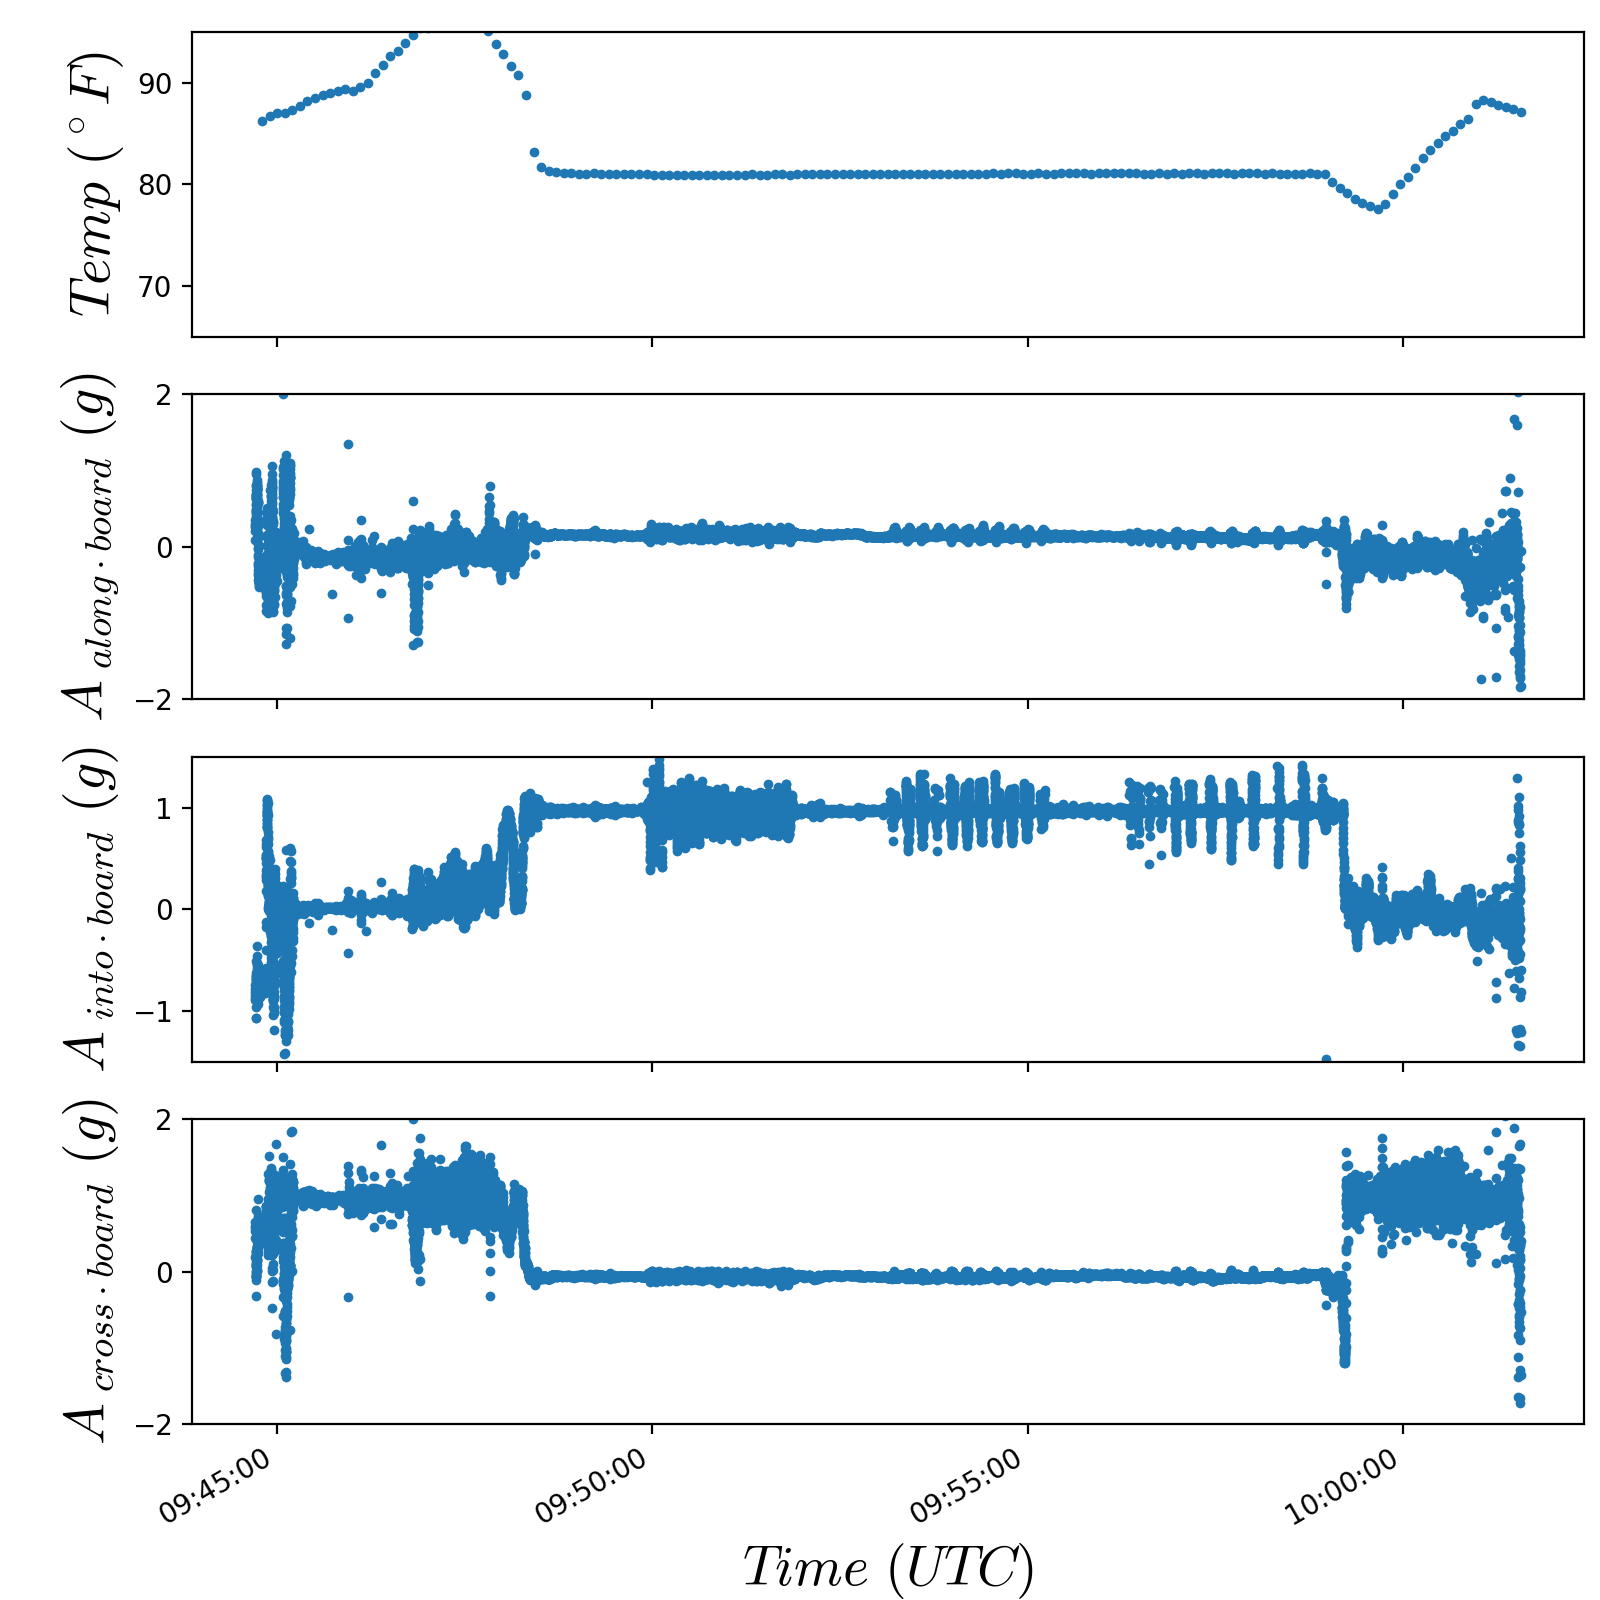

DatetimeIndex(['2018-07-23 09:44:42.915000-07:00',
               '2018-07-23 09:44:42.948000-07:00',
               '2018-07-23 09:44:42.981000-07:00',
               '2018-07-23 09:44:43.014000-07:00',
               '2018-07-23 09:44:43.047000-07:00',
               '2018-07-23 09:44:43.080000-07:00',
               '2018-07-23 09:44:43.113000-07:00',
               '2018-07-23 09:44:43.146000-07:00',
               '2018-07-23 09:44:43.179000-07:00',
               '2018-07-23 09:44:43.212000-07:00',
               ...
               '2018-07-23 10:01:33.606000-07:00',
               '2018-07-23 10:01:33.639000-07:00',
               '2018-07-23 10:01:33.672000-07:00',
               '2018-07-23 10:01:33.705000-07:00',
               '2018-07-23 10:01:33.738000-07:00',
               '2018-07-23 10:01:33.771000-07:00',
               '2018-07-23 10:01:33.804000-07:00',
               '2018-07-23 10:01:33.837000-07:00',
               '2018-07-23 10:01:33.870000-07:00',
            

/Users/jasminesimmons/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



In [23]:
#%% Plot!
fig, axs = plt.subplots(figsize = (8, 8), nrows = 4, sharex = True)
n_lines = len(ride_ids)
fsize = 20

# Set sequential color-mapping
plt.style.use('classic')
plt.style.use('fivethirtyeight')

# Nested loops to plot by fin, by ride
for i, rid in enumerate(ride_ids):
    # Fetch one ride at a time
    full_df_ride = full_df.ix[rid]
    
    # Y variables
    temp_ride = full_df_ride.loc[:, 'temp_ext_cal (oC)']
    #These were changed from /500 to /512 to fit our control findings
    A1_ride = full_df_ride.loc[:, 'IMU A1']/512
    A2_ride = full_df_ride.loc[:, 'IMU A2']/512
    A3_ride = full_df_ride.loc[:, 'IMU A3']/512
                              
    #These were changed from /500 to /8.2 to fit our control findings
    G1_ride = full_df_ride.loc[:, 'IMU G1']/8.2
    G2_ride = full_df_ride.loc[:, 'IMU G2']/8.2
    G3_ride = full_df_ride.loc[:, 'IMU G3']/8.2
    
    # Time or elapsed time on x-axis
    x_var = full_df_ride.index # this puts them all over the x-axis due to long time between sessions
    
    # Convert to local time but only here...
    pacific = pytz.timezone('US/Pacific')
    x_var_local = x_var.tz_localize(pytz.utc).tz_convert(pacific)
    
    # Plot
    axs[0].plot(x_var_local, temp_ride*1.8+32, '.', label = 'surfer '+str(i)) # full_df_ride.index, 
#    axs[0].set_ylim([17, 18])
    axs[0].set_ylabel('$Temp\ (^\circ F)$', fontsize = fsize)
        
    axs[1].plot(x_var_local, A1_ride, '.')
    axs[2].plot(x_var_local, A2_ride, '.')
    axs[3].plot(x_var_local, A3_ride, '.')
    
#    axs[2].plot(x_var, G1_ride, '.')
#    axs[2].plot(x_var, G2_ride, '.')
#    axs[2].plot(x_var, G3_ride, '.')
    
    axs[1].set_ylabel('$A_{\ along \cdot board}\ (g)$', fontsize = fsize)
    axs[2].set_ylabel('$A_{\ into \cdot board}\ (g)$', fontsize = fsize)
    axs[3].set_ylabel('$A_{\ cross \cdot board}\ (g)$', fontsize = fsize)
    
    axs[3].set_xlabel('$Time\ (UTC)$', fontsize = fsize)
    
    axs[0].set_ylim([65, 95.])
    axs[1].set_ylim([-2.00, 2.00])
    axs[2].set_ylim([-1.50, 1.50])
    axs[3].set_ylim([-2.00, 2.00])
    
#leg = axs[0].legend(loc = 'lower right', fontsize = fsize-6)
fig.autofmt_xdate()
#fig.tight_layout()
plt.subplots_adjust(left = 0.12, right = 0.99, top = 0.98, bottom = 0.11,
                    hspace = 0.19, wspace = 0.00)
date_format = '%H:%M:%S'
myFmt = mdates.DateFormatter(date_format, tz = pacific)
axs[2].xaxis.set_major_formatter(myFmt)

#plt.savefig('/Users/pjb/Desktop/PJB-JR-SmartfinSurf.png', dpi = 1200)
plt.show()

print(x_var_local)

### Checking data for Swells and their Periods

In [24]:
print('Running WaveStats Algorithm:')
#Copy original .CSV dataframe
my_full_df = full_df_filt

#print(my_full_df)


#Lists with scaled units:
     
#Accelerometer arrays, already scaled to m/s^2
imua1_list = my_full_df.loc[:, "IMU A1"] 
imua2_list = my_full_df.loc[:, "IMU A2"] 
imua3_list = my_full_df.loc[:, "IMU A3"] 

length = len(imua2_list)
print("The length is: ", length)
#print(imua2_list)


#Gyroscope arrays, already scaled to degrees, need to * 0.0174533 to get rad/s
imug1_list = my_full_df.loc[:, "IMU G1"] * 0.0174533
imug2_list = my_full_df.loc[:, "IMU G2"] * 0.0174533
imug3_list = my_full_df.loc[:, "IMU G3"] * 0.0174533
     
#print(imug3_list)

#Elapsed Time array
time_e_list = full_df_filt_mod.loc[:,"Time_y"]


#Calculate Time Offsets from Elapsed Time array:
time_o_array = np.array([0.0])

index = 1
while index < (len(time_e_list) - 1):
    raw_ms = time_e_list[index+1] - time_e_list[index] #gets time in ms
    raw_ms = raw_ms*(10**-3)                           #convert time to s
    time_o_array = np.append(time_o_array,raw_ms)
    index += 1

#To show time offset array:    
#print(time_o_array)


#Filtering data from datasheet:




#Using imus.analytical from skinematics

#Need to convert lists to a (N,3) ndarray
#Accelerometers:
xas = [[i] for i in imua1_list]
yas = [[j] for j in imua2_list]
zas = [[k] for k in imua3_list]

#Gyroscops:
xgs = [[i] for i in imug1_list]
ygs = [[j] for j in imug2_list]
zgs = [[k] for k in imug3_list]

#Need to convert from degrees/sec to radians/sec

#Parameters:
initial_orientation = np.array([[ 1., 0., 0.], [ 0., 1., 0.], [ 0., 0., 1.]]) #rotation matrix, ndarray(3,3)
omegas = np.hstack((xgs,ygs,zgs)) #angular velocity in rad/s, ndarray (N,3)
initial_pos = [0,0,0] #initial position in [m]
accs = np.hstack((xas,yas,zas)) #Linear acceleration, in [m/s^2], (ndarray(N,3))
rate = 30 #sampling rate in [Hz]

print(accs)

#Returns: 
#Quaternion orientation--q (ndarray(N,3))
#Position in space [m]--pos (ndarray(N,3))
quaternions, positions = imus.analytical(initial_orientation, omegas, initial_pos, accs, rate)

print("\n")
print("Printing quaternions:")
print("\n")
print(quaternions)

print("\n")
print("Printing positions:")
print("\n")
print(positions)


#I want to get the vertical accelerations from (quaternion,acceleration)!!


##To view orientatiion of the fin as a visualization:
#viewer = view.Orientation_OGL(quaternions, rate = 33) #Make the simulation run at 250ms intervals, so show "real time" movement
#viewer.run(looping=False, rate=30)                     #Force the simulation to run at 4Hz to match the 250ms intervals
#pygame.display.quit()
#pygame.quit()


#Convert the quaternions into euler angles:
eulers = quat.quat2seq(quaternions, seq="Euler")

print("\n")
print("Printing Euler angles:")
print(eulers)

#Get the angle between the two vectors: .... ?
#Parameters: vector.angle(v1,v2)
#v1 (array (N,) or (M,N)) – vector 1
#v2 (array (N,) or (M,N)) – vector 1
#Returns: 
#angle – angle between v1 and v2, double or array(M,)

#v1 = 
#v2 = 
#angles = vector.angle(v1,v2)




Running WaveStats Algorithm:
The length is:  23327
[[  2.64410156  -7.28085938   6.38033203]
 [  3.46798828  -8.79451172   4.31103516]
 [  2.06929688  -8.54542969   5.57560547]
 ..., 
 [-31.67173828  21.84257813  -5.24988281]
 [-17.99138672 -11.84097656 -13.33546875]
 [ -0.57480469  -7.98978516   3.96615234]]


Printing quaternions:


[[  1.00000000e+00   0.00000000e+00   0.00000000e+00  -6.93889390e-18]
 [  9.98975686e-01  -2.22724339e-02  -1.00534655e-02  -3.80847158e-02]
 [  9.95973297e-01  -4.17825095e-02  -2.96769530e-02  -7.35574044e-02]
 ..., 
 [ -5.21397314e-01   4.69530329e-01  -1.43960062e-01  -6.97826348e-01]
 [ -4.37290012e-01   5.08053190e-01  -2.23762392e-01  -7.07523706e-01]
 [ -3.45624753e-01   5.56939497e-01  -2.61683501e-01  -7.08437487e-01]]


Printing positions:


[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.17499938e-04  -5.70954685e-04   1.60237957e-04]
 [  5.22812967e-04  -2.42707004e-03   7.20836115e-04]
 ..., 
 [ -1.73105917e+06   6.46032179e+05 

23327
23327
23327


<IPython.core.display.Javascript object>


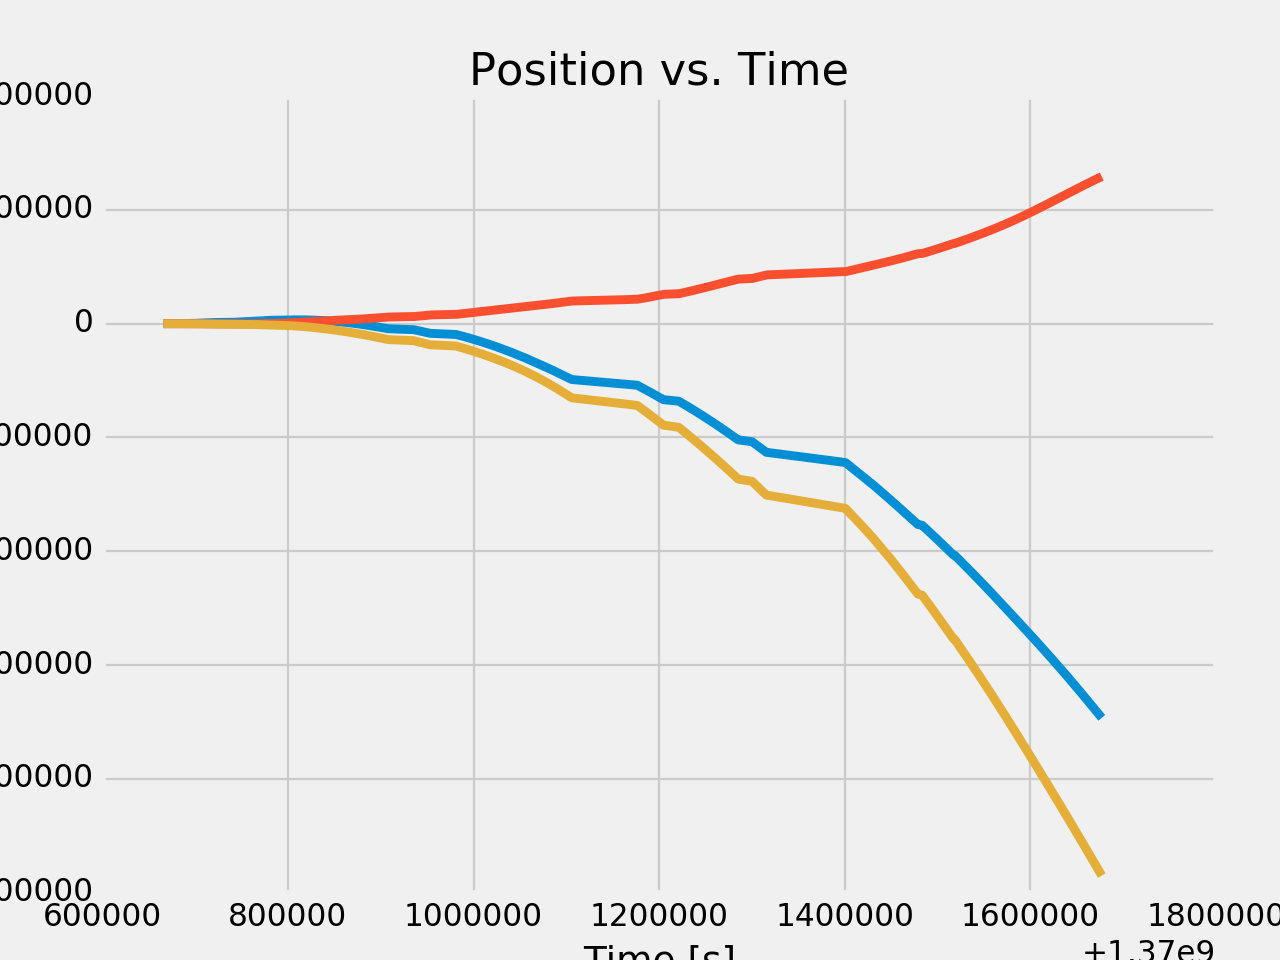

<IPython.core.display.Javascript object>


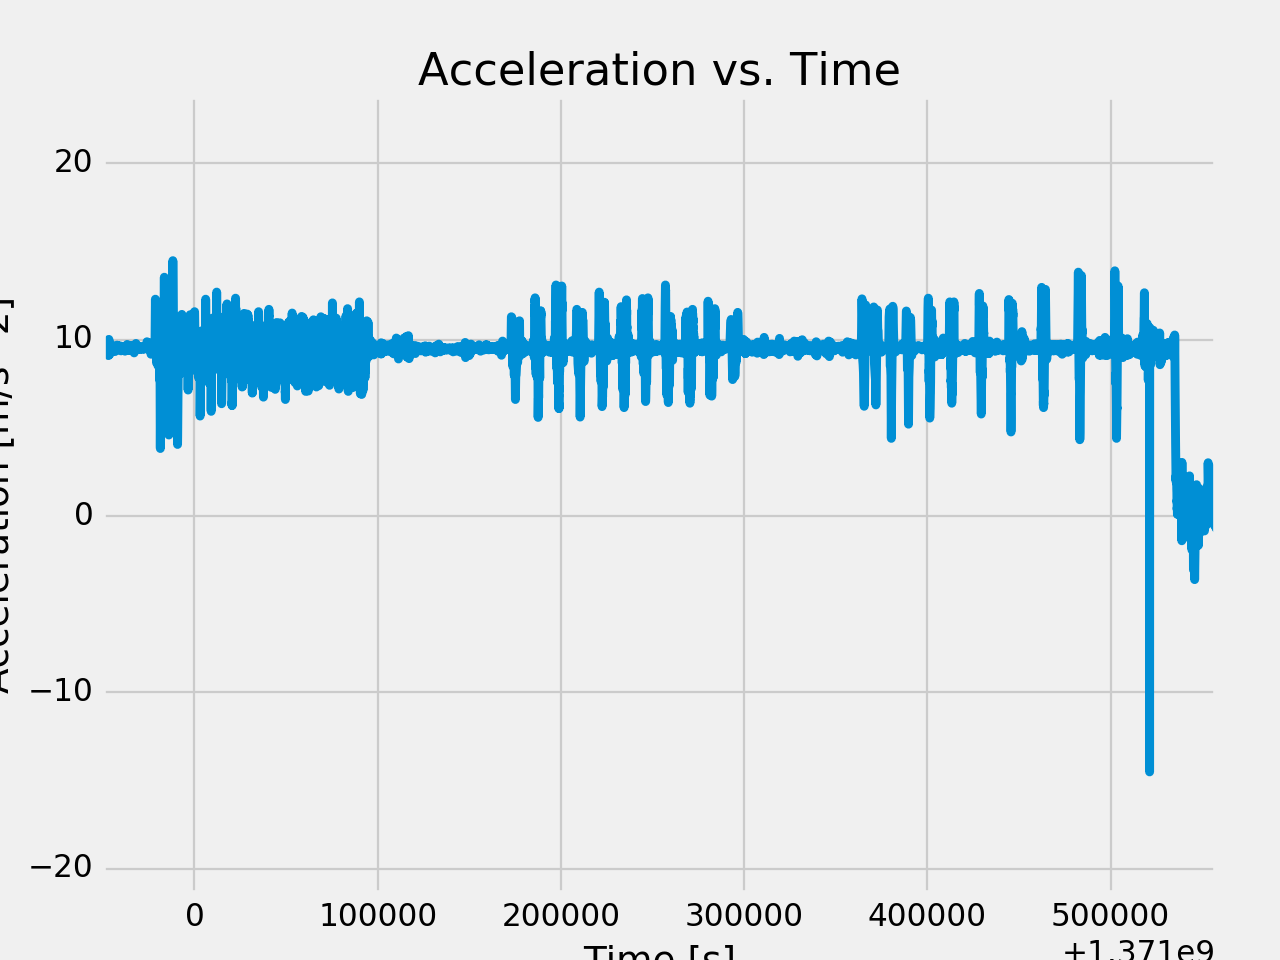

In [101]:
#--------Graph positions:

time_array = np.array(time_e_list)
pos_array = np.array(positions)
acc_array = np.array(imua2_list)

print(len(time_array))
print(len(pos_array))
print(len(acc_array))

fig1, ax1 = plt.subplots()
ax1.plot(time_array, pos_array)
ax1.set_title("Position vs. Time")
ax1.set_ylabel("Position [m]")
ax1.set_xlabel("Time [s]")

fig2, ax2 = plt.subplots()
ax2.plot(time_array, acc_array)
ax2.set_title("Acceleration vs. Time")
ax2.set_ylabel("Acceleration [m/s^2]")
ax2.set_xlabel("Time [s]")

#plt.subplot(1,1,1)
#plt.plot(time_array, pos_array)
#plt.title("Position vs. Time")
#plt.ylabel("Position [m]")
#plt.xlabel("Time [s]")

#plt.subplot(2,1,2)
#plt.plot(time_array, acc_array)
#plt.title("Accelereation vs. time")
#plt.ylabel("Acc [m/s^2]")
#plt.xlabel("Time [s]")
        
plt.show()


# Importing Sensor Data and Setting Up for Scikit Kinematics

#### Make sure rate is set to either 4 Hz or 33 Hz

In [32]:
# Get data from CSV for acceleration, gyro, and magneto

# So to use Scikit properly..., it needs an in-File to read to get the data
# I tried to do this without using an input file since the data is still scaled in the CSV, and I'm not sure if that will
#      affect the output of the quaternions. The main concern is the scaling of the magnetometer and acceleration data,
#      since the angular velocity just has to be converted to rad/s, which is simple to do.

rate = 33     #Update frequency in Hz for surfing motion

#initial_orientation = np.eye(3)
#print(initial_orientation)
#initial_position = np.array([0,0,0])

#MPU9250 = Xsens(inFile=None, q_type='kalman', R_init=initial_orientation, calculate_position=True, pos_init=initial_position, in_data=None)

#MPU9250 = imus.IMU_Base(inFile=None, q_type='kalman', R_init=initial_orientation, calculate_position=True, pos_init=initial_position, in_data=None)
# Just using kalman option for now, since "None" seems to be more complicated
                        

acc = full_df_filt_mod.loc[:,['IMU A1 [m/s^2] long axis - = forwards', 'IMU A2 [m/s^2] vertical + = down',\
                              'IMU A3 [m/s^2] short axis + = right']]
# print(acc.size)    #Check to make sure thr right number of numbers are present, should by 161*3 = 483


gyr = full_df_filt_mod.loc[:,['IMU G1 [deg/s] + = flip left', 'IMU G2 [deg/s] + = turning right', 'IMU G3 [deg/s] pitch upwards']]
#print(gyr.size)

gyr_rad = gyr * np.pi / np.float(180)     #Convert gyroscope readings from deg/s to rad/s for input to Scikit functions
#print(gyr_rad)


magn = full_df_filt_mod.loc[:,['IMU M1 [uTeslas] + = looking forward', 'IMU M2 [uTeslas] + = looking upwards', 'IMU M3 [uTeslas] + = looking right']]
#print(magn.size)

# Convert the sliced dataframes into ndarrays for the kalman function below
acc = acc.values
gyr_rad = gyr_rad.values
magn = magn.values

### Getting Quaternions from IMU Data using Kalman's function

Currently we're getting a lot of drift in the gyroscopic readings. The initial magneto readings seem to be aligning with the axis in the animation, but eventually get offset by the gyro drift.

We'll have to find a good calibration to get rid of this if we use the Kalman function here. Hopefully the other functions can eliminate this drift. Otherwise, we may have to manually write code to do these quaternion functions...

In [33]:
# Calculate the quaternions relative to the Earth's magnetic reference frame from the rate, accelerometer, gyro,
#     and magnetic data. All functions automatically iterate through arrays unless specified otherwise
quat_array = imus.kalman(rate,acc,gyr_rad,magn)
#print(quat_array)

deg_from_quats = quat.quat2deg(quat_array)     # Find rotational angles from the quaternion orientation
#print(deg_from_quats)


calc_angular_vel = quat.calc_angvel(quat_array, rate, winSize = 3, order = 2)     #Find ang velocities based on quaternions
#print(calc_angular_vel)
print(len(quat_array))
print(quat_array)

#view.orientation(quat_array, out_file=None, title_text='Ride 13735 Filtered', deltaT = 1000)
viewer = view.Orientation_OGL(quat_array, rate = 33) #Make the simulation run at 250ms intervals, so show "real time" movement
viewer.run(looping=False, rate=30)                     #Force the simulation to run at 4Hz to match the 250ms intervals

# Close the window to prevent kernel crash at the end
pygame.display.quit()
pygame.quit()
#view.ts(quat_array)

7022
[[  1.00000000e+00  -2.77555756e-17   0.00000000e+00   1.73472348e-18]
 [  9.54331699e-01   6.43752880e-02   1.10756069e-01   2.69888724e-01]
 [  8.20089081e-01  -2.02711514e-01   2.18749584e-01  -4.88375430e-01]
 ..., 
 [ -3.62724308e-01   4.53345474e-01  -1.67856638e-01   7.96701391e-01]
 [ -3.87938432e-01   4.62060845e-01  -2.34261311e-01   7.62315674e-01]
 [ -3.87856813e-01   4.81251369e-01  -2.48898781e-01   7.45663201e-01]]


NameError: name 'quit' is not defined

### Using Madgwick's Algorithm

In [ ]:
# Calculate the quaternion's relative to the Earth's magnetic reference frame from the rate, accelerometer, gyro,
#     and magnetic data, as well as a B (beta) error offset for gyroscopic readings. All functions automatically iterate
#     through arrays unless specified otherwise


# Madgwick class
# SamplePeriod -> seconds, Beta -> average gyroscopic error for each axis (I averaged axes to get single number)
#     Beta = sqrt(3/4) * (error in bits)/8.2 * (pi/180)
calculator = imus.Madgwick(SamplePeriod=0.250, Beta=0.015299, Quaternion=[1, 1, 1, 1])
print(len(gyr_rad))
print(gyr_rad.shape)
print(len(acc))
print(acc.shape)
print(len(magn))
print(magn.shape)
calculator.Update(gyr_rad, acc, magn)